<a href="https://colab.research.google.com/github/tr41z/machine-learning/blob/main/AI_IDS_SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Threat Detection using UNSW-NB15 Dataset** 🔐

In this notebook, I’ll be building an **threat detection model** using the **UNSW-NB15 dataset**. The main objective is to detect unusual or unexpected patterns in network traffic that could represent potential security threats.

### 🛠️ **Tools and Libraries I'll Use:**
- **Python** for data preprocessing and model building.
- **scikit-learn** and optionally **TensorFlow/PyTorch** for machine learning algorithms to identify anomalies.
- **Pandas** and **NumPy** for data manipulation and processing.
- **Matplotlib** and **Seaborn** for visualizing the data and results.

### 📊 **Dataset Overview:**
The **UNSW-NB15** dataset includes both normal and abnormal network traffic, making it ideal for threat detection. I'll be working with:
- **49 features** that describe various aspects of network traffic.
- A combination of normal and anomalous traffic data, allowing the model to learn the difference between the two.

By the end of this notebook, I'll have trained and evaluated a machine learning model that can detect anomalies in network traffic, which could be used for tasks like intrusion detection or identifying unusual network activity.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# 🧸 Getting familiar with data

### 📦 **Importing Necessary Libraries**

> In this section, I’m importing the libraries that will be used for `data manipulation`, `visualization`, `preprocessing`, and `machine learning`.


In [ ]:
!pip install dtreeviz catboost dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import logging

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Data encoding, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import plotly.express as px

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### 🫙 Mounting google drive to get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 📚 Reading data and visualising, analysing it

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_training-set.csv'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_testing-set.csv'

train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [ ]:
df = pd.concat([train_data,test_data]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


# 💡 Data Preprocessing

In [ ]:
# Convert 'state' column to categorical type and store the original categories
df['state'] = df['state'].astype('category')
original_states = df['state'].cat.categories.tolist()

In [ ]:
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes

df['state'] = df['state'].replace(10, -1)
df['attack_cat'] = df['attack_cat'].astype('category')

In [ ]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float64 
 1   proto              257673 non-null  int16   
 2   service            257673 non-null  int8    
 3   state              257673 non-null  int8    
 4   spkts              257673 non-null  int64   
 5   dpkts              257673 non-null  int64   
 6   sbytes             257673 non-null  int64   
 7   dbytes             257673 non-null  int64   
 8   rate               257673 non-null  float64 
 9   sttl               257673 non-null  int64   
 10  dttl               257673 non-null  int64   
 11  sload              257673 non-null  float64 
 12  dload              257673 non-null  float64 
 13  sloss              257673 non-null  int64   
 14  dloss              257673 non-null  int64   
 15  sinpkt             257673 non-null

In [ ]:
X = df.drop(columns = ['attack_cat', 'label'])
y = df['attack_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [ ]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [ ]:
attacks_map = {
    0: 'Normal',
    1: 'Backdoor',
    2: 'Analysis',
    3: 'Fuzzers',
    4: 'Shellcode',
    5: 'Reconnaissance',
    6: 'Exploits',
    7: 'DoS',
    8: 'Worms',
    9: 'Generic'
}

### 🖊️ Visualising some data

attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


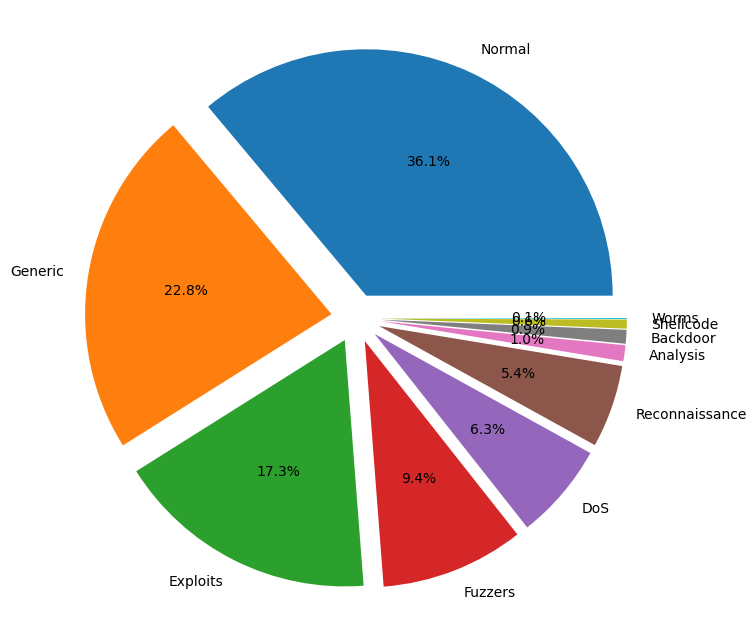

In [ ]:
# Get valid attacks counts, including normal
validAttacks = df['attack_cat'].value_counts()

# Exclude categories with zero counts from the pie chart
validAttacks = validAttacks[validAttacks > 0]

print(validAttacks)

# Prepare explode list with same length as validAttacks
explode = [0.1] * len(validAttacks)  # Slightly explode all slices for visibility

plt.figure(figsize=(15, 8))
plt.pie(validAttacks, labels=validAttacks.index, autopct='%1.1f%%', explode=explode)
plt.show()

6    65059
5    41403
3    31025
4    17038
2    11419
7     9750
0     1888
1     1623
8     1039
9      127
Name: count, dtype: int64


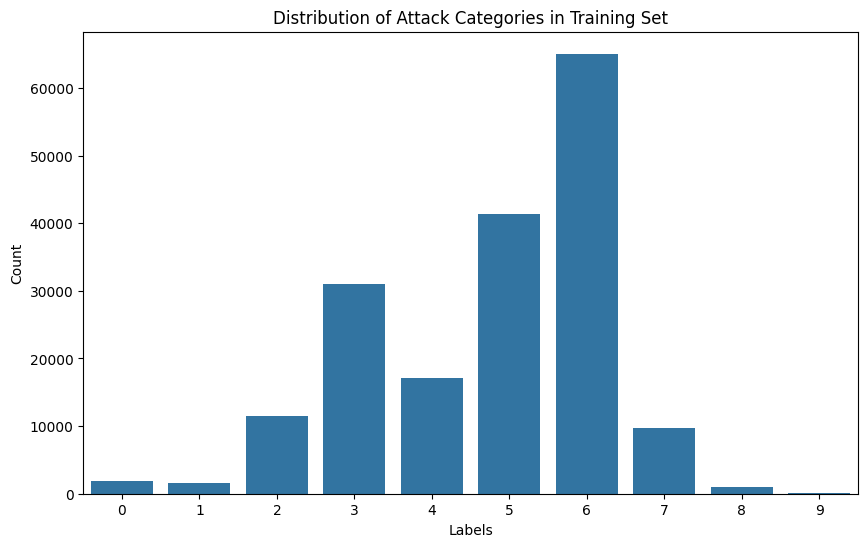

In [ ]:
# Convert y_train to a pandas Series
y_train_series = pd.Series(y_train)

# Count the occurrences of each label
train_label_counts = y_train_series.value_counts()

print(train_label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=train_label_counts.index, y=train_label_counts.values)
plt.title('Distribution of Attack Categories in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

6    27941
5    17468
3    13500
4     7208
2     4934
7     4237
0      789
1      706
8      472
9       47
Name: count, dtype: int64


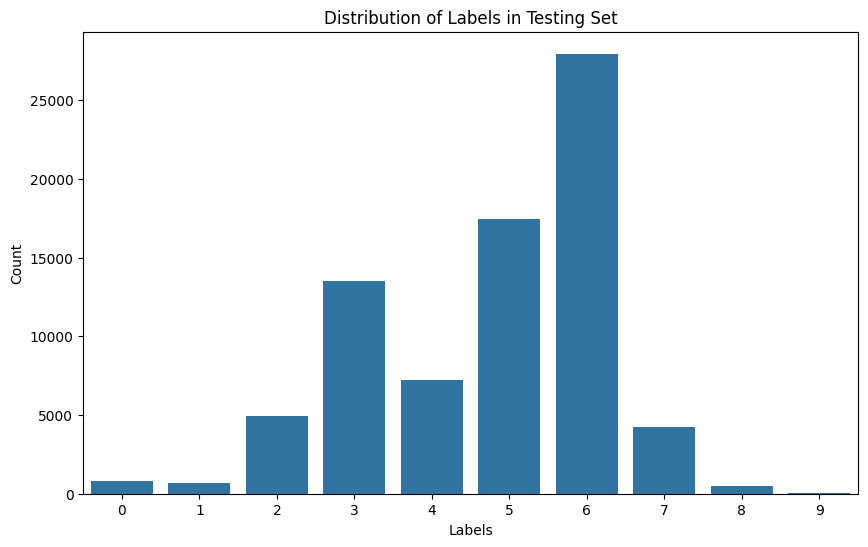

In [ ]:
# Convert y_train to a pandas Series
y_test_series = pd.Series(y_test)

# Count the occurrences of each label
test_label_counts = y_test_series.value_counts()

print(test_label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=test_label_counts.index, y=test_label_counts.values)
plt.title('Distribution of Labels in Testing Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# 🤖 Machine Learning

### 🌲 **Fitting a Random Forest Model and Evaluating Performance**

> In this step, I trained all available **scikit-learn models** and used it to predict the test set outcomes.

- **Model Accuracy**: I calculated the overall accuracy to assess how well the model is performing.
- **Classification Report**: The detailed classification report includes:
  - **Precision**: How many of the predicted positives were correct.
  - **Recall**: How many actual positives were correctly predicted.
  - **F1-Score**: The balance between precision and recall.

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((180371, 42), (180371,), (77302, 42), (77302,))

In [ ]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1_score = 2*(precision*recall)/(precision+recall)

    print("\n\n\n=================================================================================================")

    # Print the metrics
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cross = pd.crosstab(pd.Series(y_test, name='Actual'),
                        pd.Series(y_pred, name='Predicted'))

    # Calculate percentages
    cross_percent = (cross / cross.sum().sum() * 100).round(2)

    # Create annotations with both percentages and counts
    annotations = cross_percent.astype(str) + "%\n" + cross.astype(str)

    # Replace numerical labels in confusion matrix axis
    attack_labels = [attacks_map[label] for label in sorted(attacks_map.keys())]

    # Plot the heatmap with updated labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(cross, annot=annotations, fmt='', cmap="rocket_r", cbar=False,
                linewidths=1, linecolor='black', annot_kws={"size": 12},
                xticklabels=attack_labels, yticklabels=attack_labels)

    # Add labels and title
    plt.title(f'Confusion Matrix with Attack Names for {type(model).__name__}', fontsize=16)
    plt.xlabel('Predicted Attack Type', fontsize=12)
    plt.ylabel('Actual Attack Type', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {'Recall': recall, 'Precision': precision, 'Accuracy': accuracy}

In [ ]:
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    ExtraTreesClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    LGBMClassifier(),
]

results = {}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.





Recall: 0.5540
Precision: 0.4063
Accuracy: 0.5540


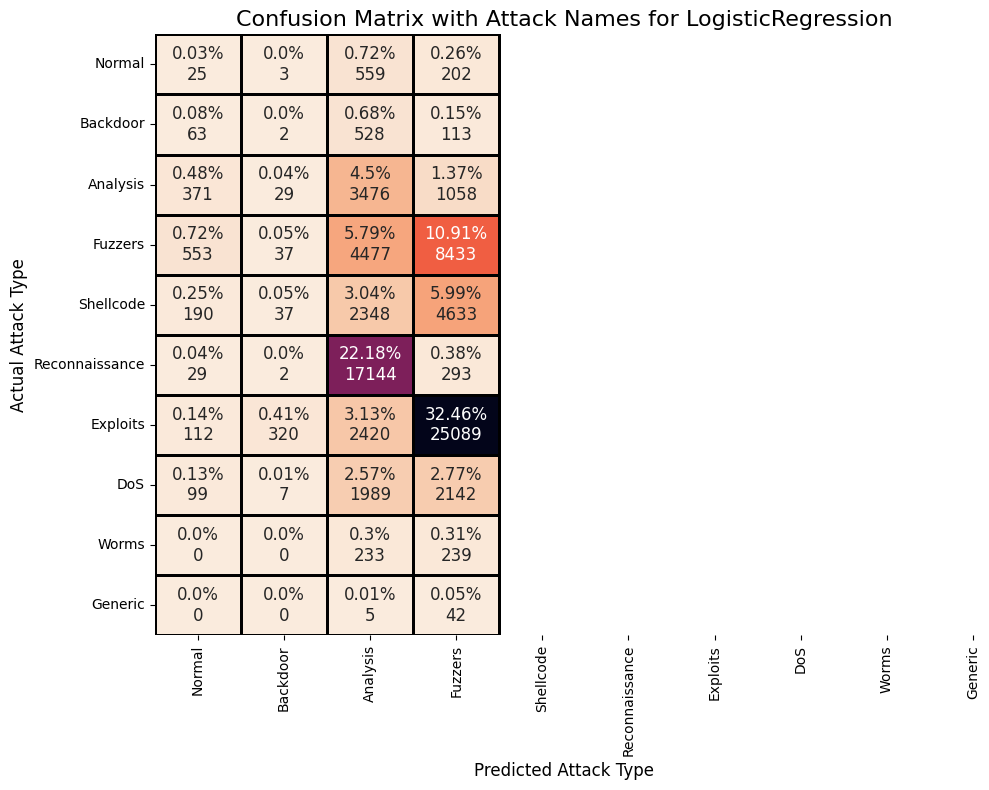




Recall: 0.6561
Precision: 0.6669
Accuracy: 0.6561


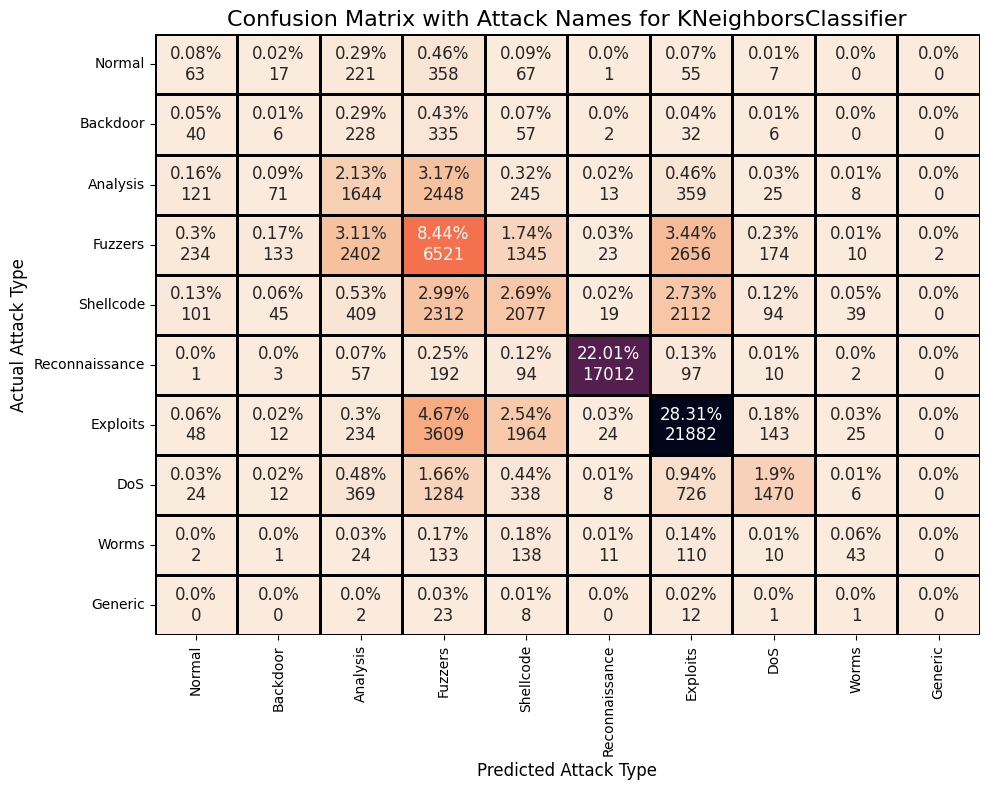




Recall: 0.8051
Precision: 0.8050
Accuracy: 0.8051


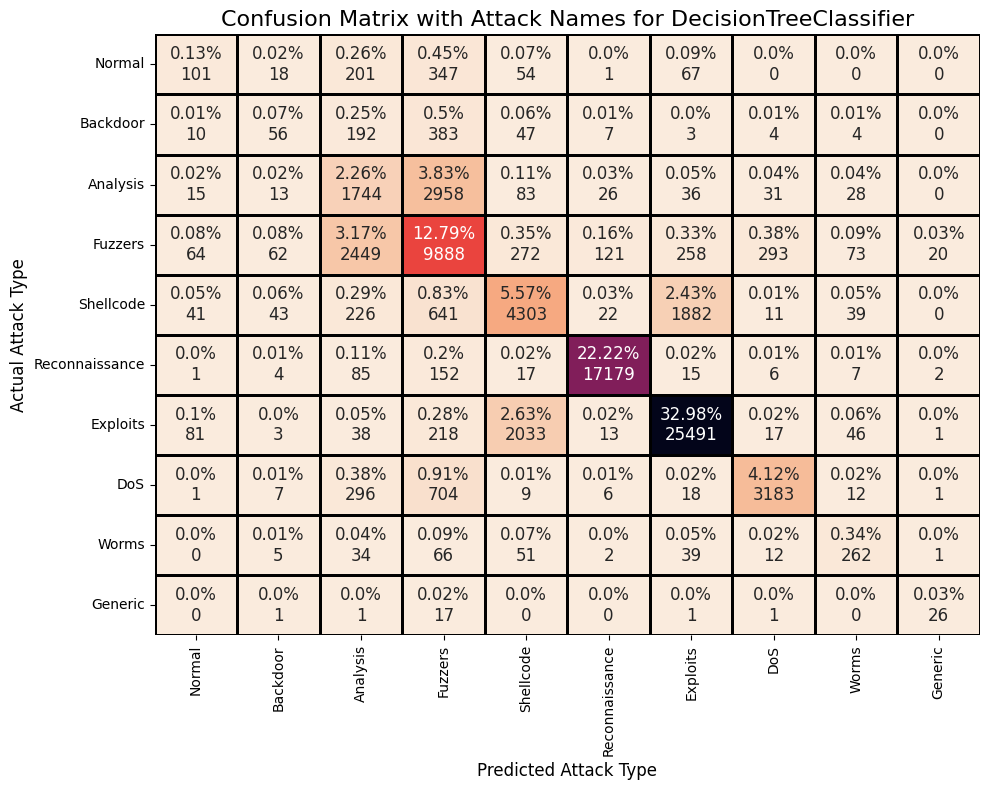




Recall: 0.8280
Precision: 0.8250
Accuracy: 0.8280


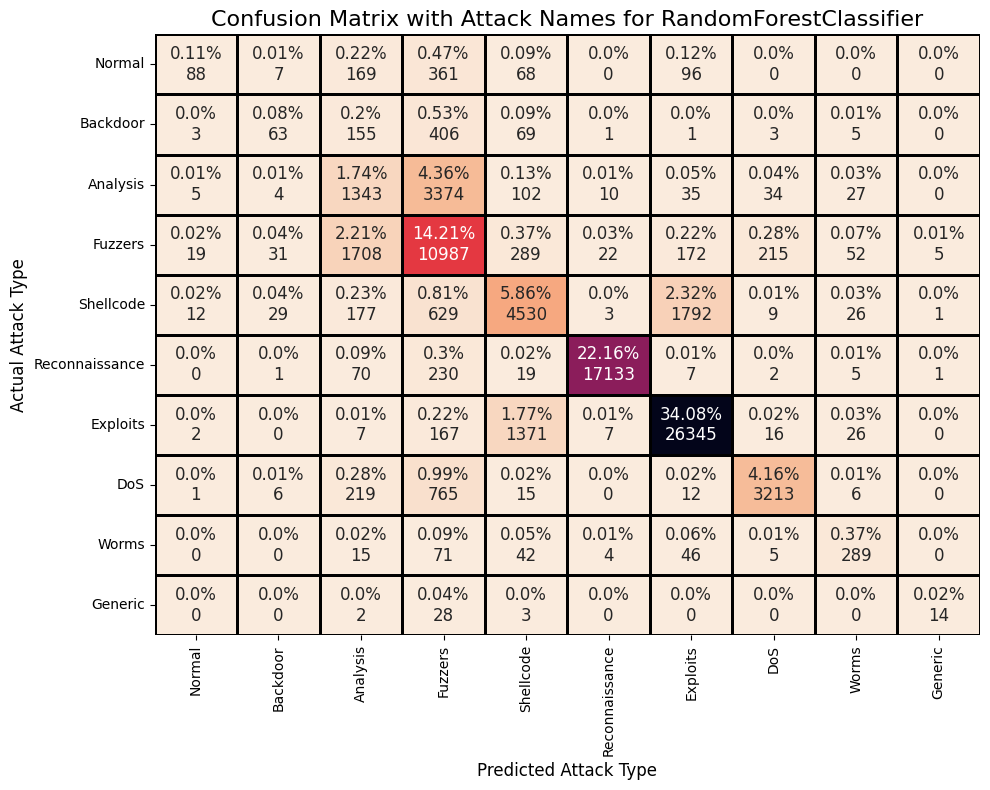




Recall: 0.8187
Precision: 0.8107
Accuracy: 0.8187


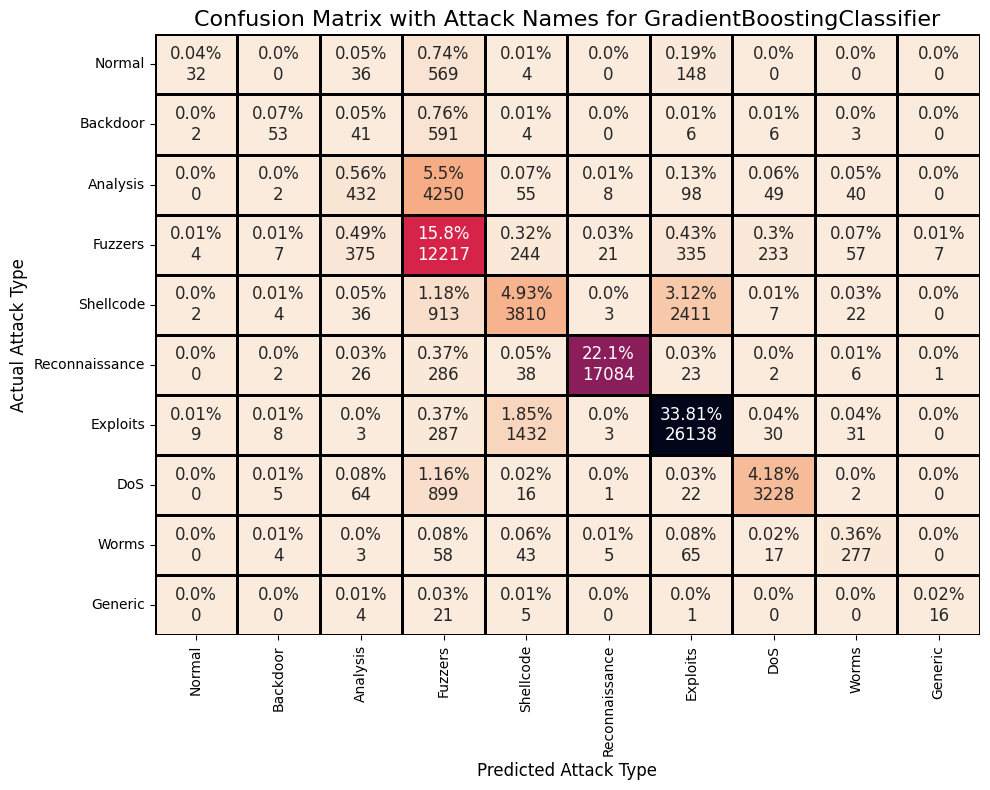

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.





Recall: 0.4509
Precision: 0.5897
Accuracy: 0.4509


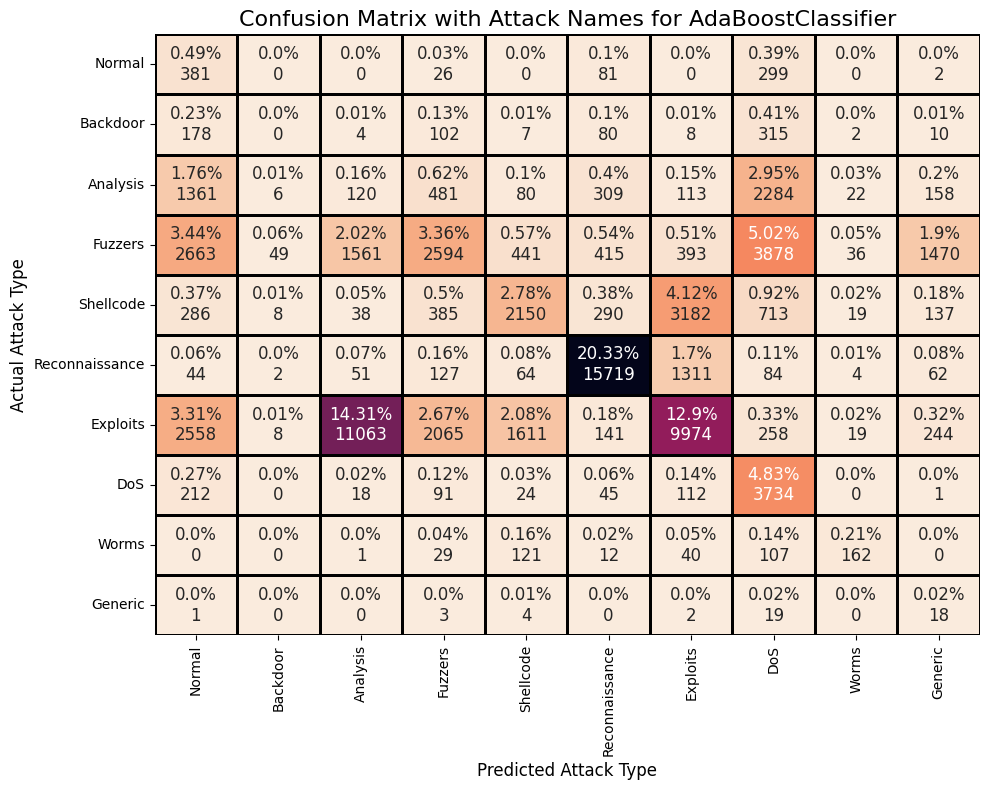

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.





Recall: 0.4407
Precision: 0.5839
Accuracy: 0.4407


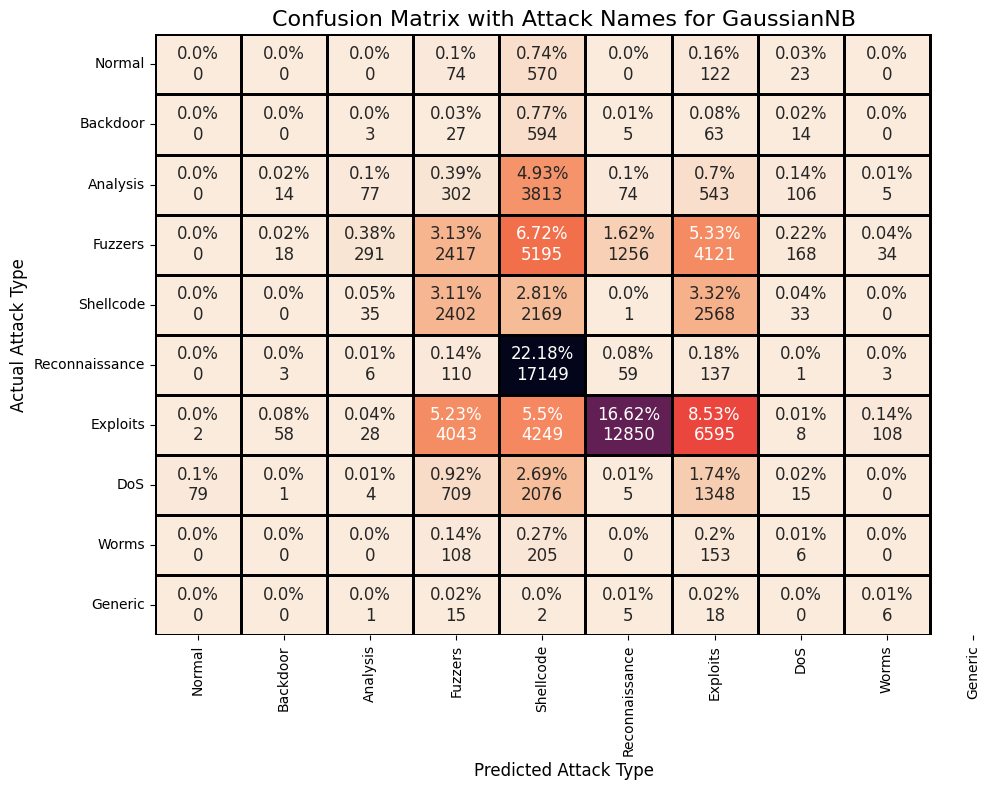

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.





Recall: 0.6676
Precision: 0.7747
Accuracy: 0.6676


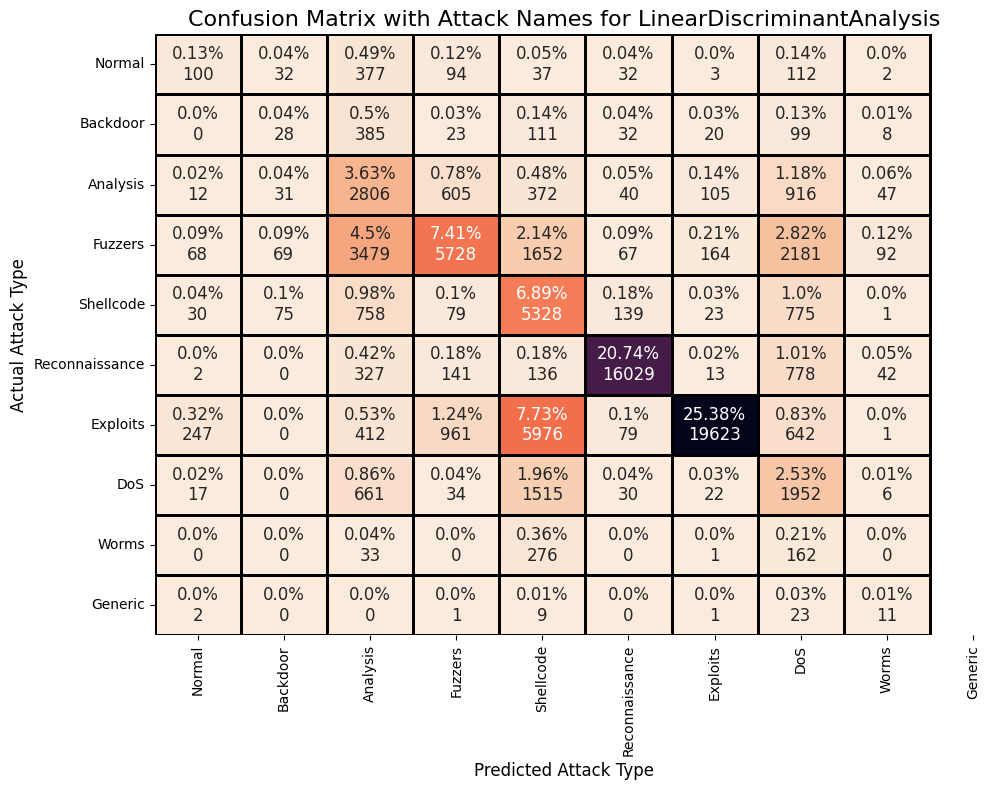

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear





Recall: 0.5728
Precision: 0.7851
Accuracy: 0.5728


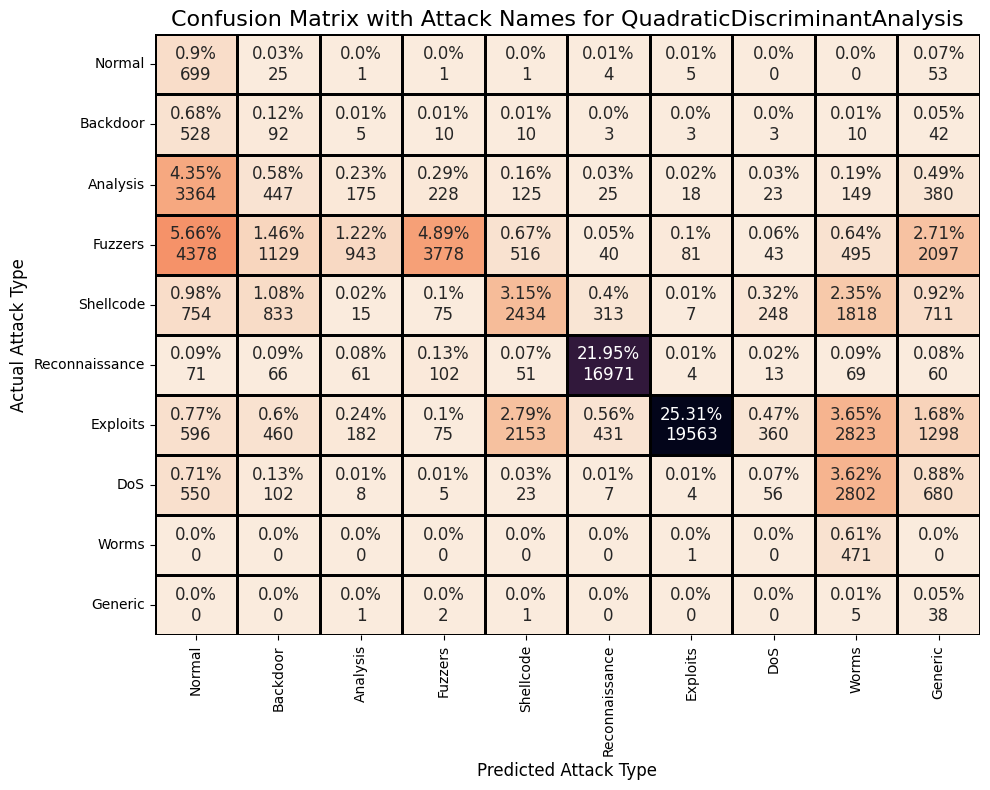




Recall: 0.8262
Precision: 0.8233
Accuracy: 0.8262


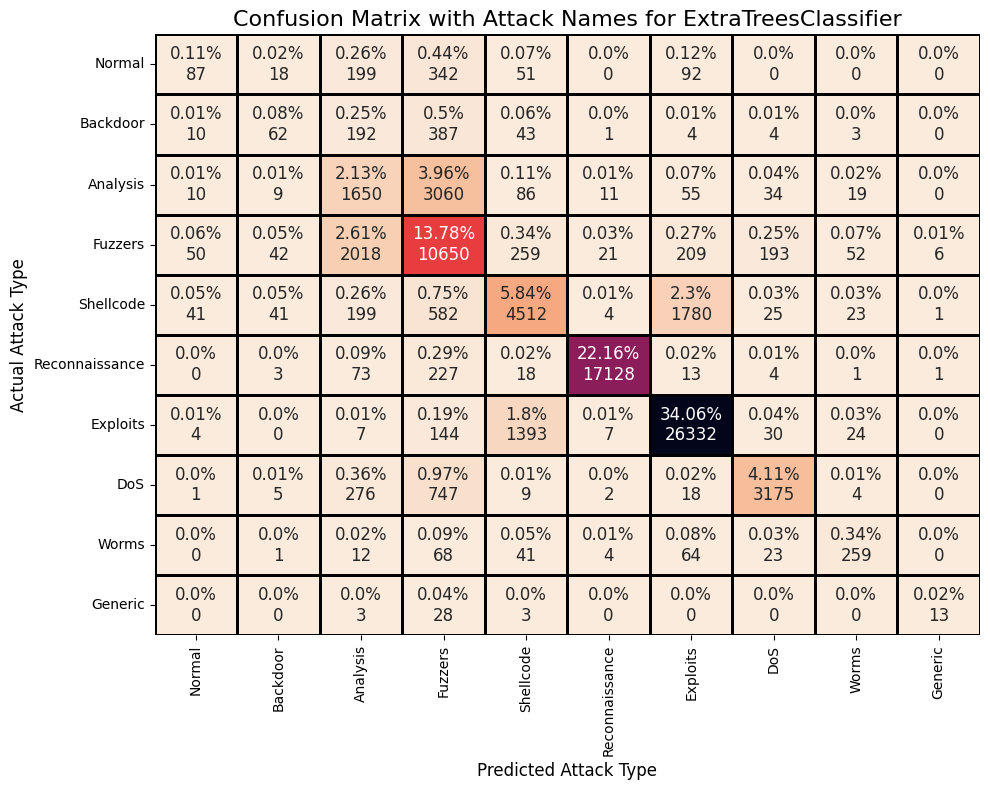




Recall: 0.8215
Precision: 0.8206
Accuracy: 0.8215


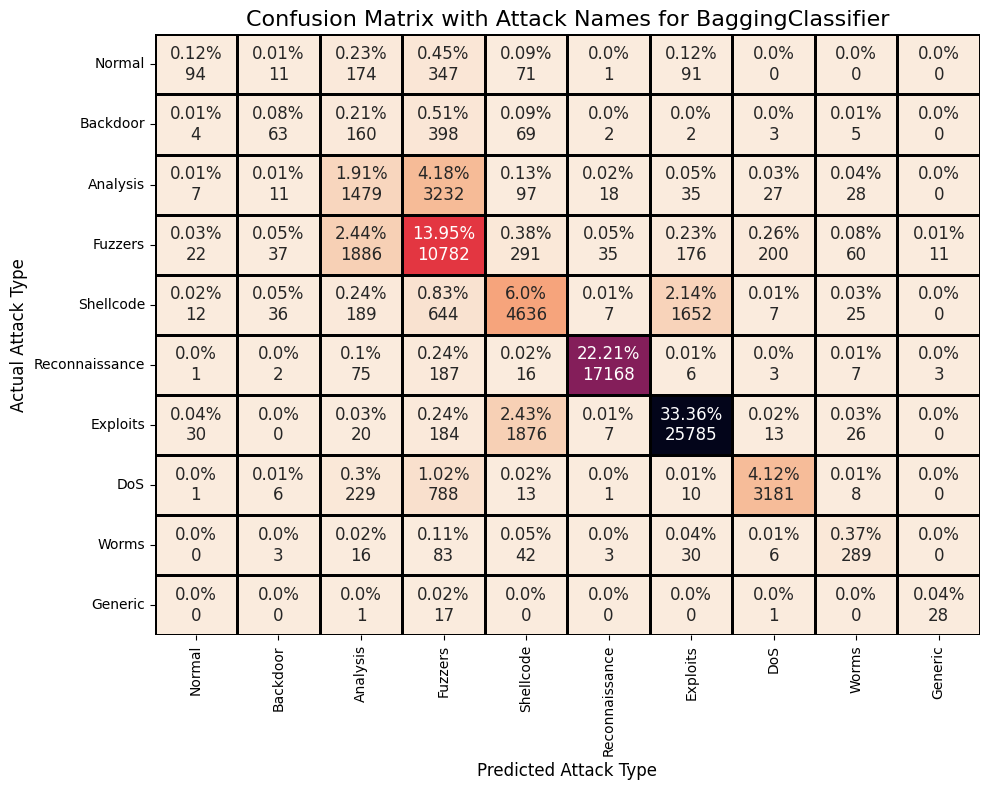

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:10:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.






Recall: 0.8354
Precision: 0.8330
Accuracy: 0.8354


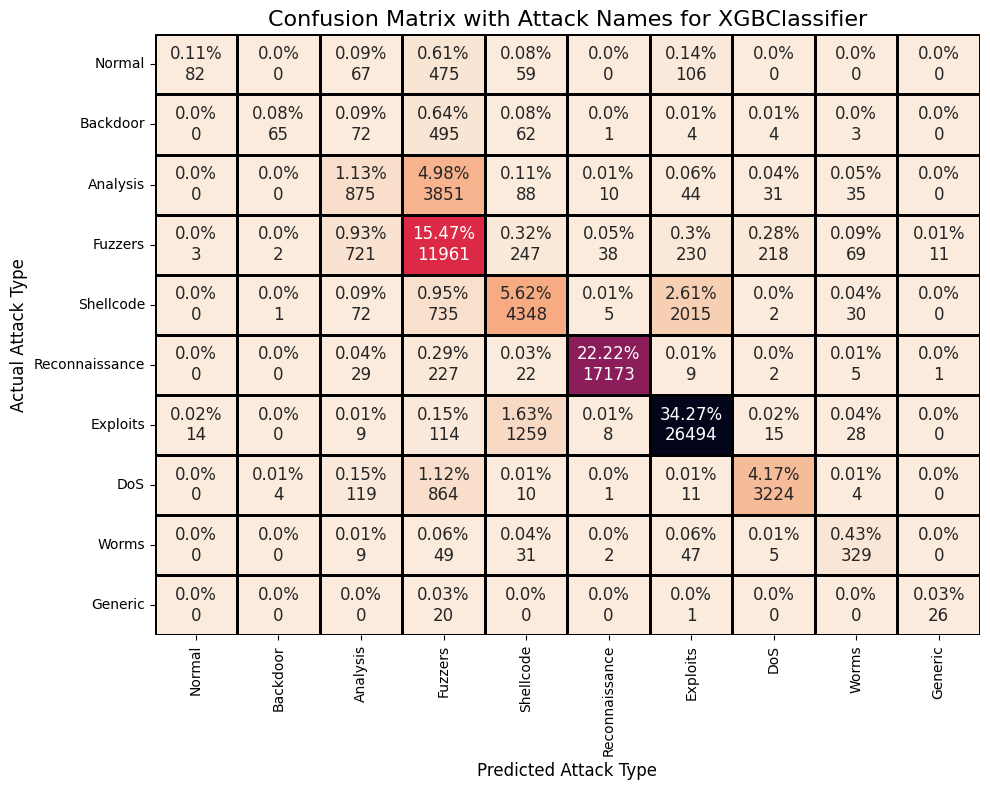

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6188
[LightGBM] [Info] Number of data points in the train set: 180371, number of used features: 42
[LightGBM] [Info] Start training from score -4.559498
[LightGBM] [Info] Start training from score -4.710740
[LightGBM] [Info] Start training from score -2.759737
[LightGBM] [Info] Start training from score -1.760223
[LightGBM] [Info] Start training from score -2.359570
[LightGBM] [Info] Start training from score -1.471662
[LightGBM] [Info] Start training from score -1.019721
[LightGBM] [Info] Start training from score -2.917749
[LightGBM] [Info] Start training from score -5.156757
[LightGBM] [Info] Start training from score -7.258584



Recall: 0.8127
Precision: 0.7993
Accuracy: 0.8127


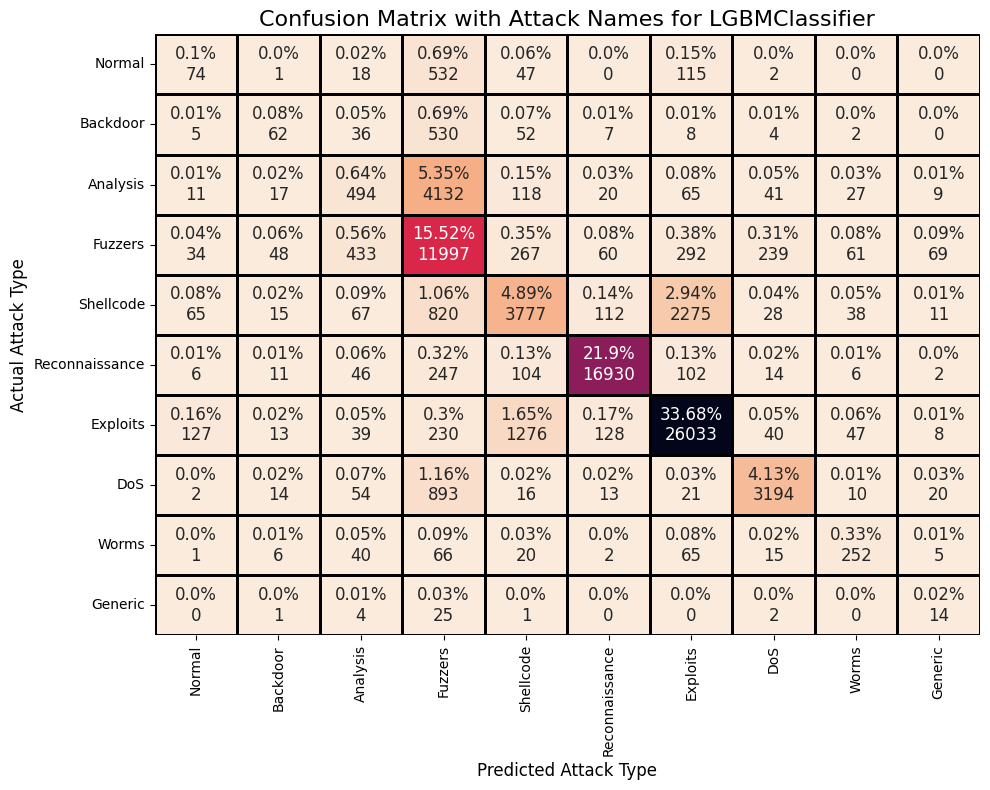

In [ ]:
for model in models:
  results[model] = model_evaluation(model)

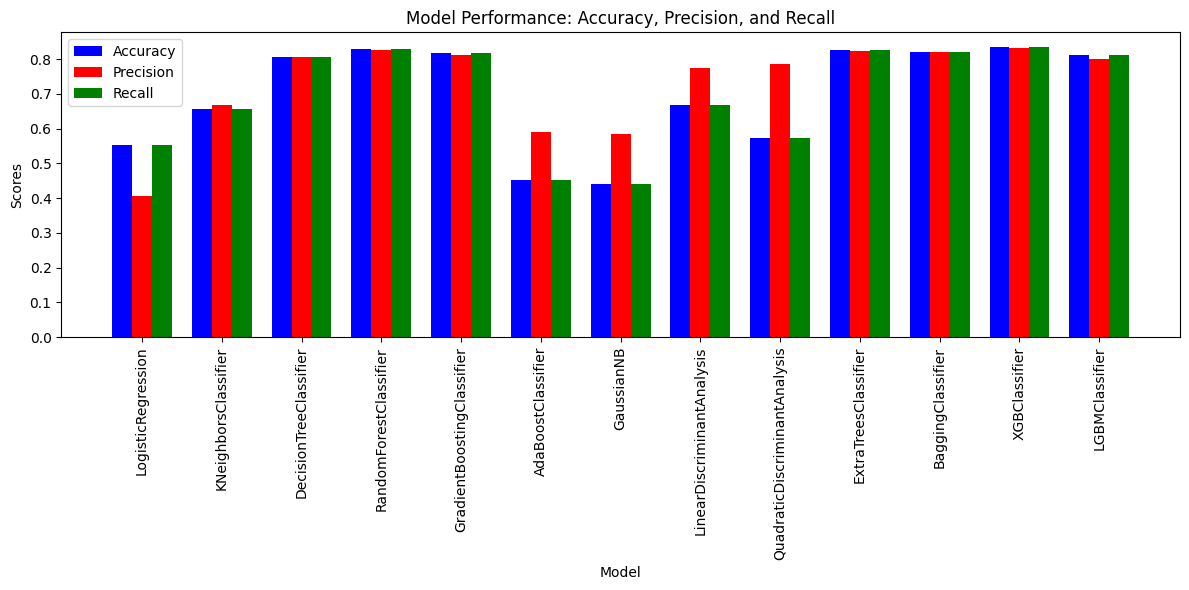

In [ ]:
# Extracting model names, accuracies, precisions, and recalls
model_names = []
accuracies = []
precisions = []
recalls = []

for model, metrics in results.items():
    model_names.append(type(model).__name__)
    accuracies.append(metrics['Accuracy'])
    precisions.append(metrics['Precision'])
    recalls.append(metrics['Recall'])

# Setting the bar width and positions
bar_width = 0.25
x = np.arange(len(model_names))

# Creating the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, accuracies, width=bar_width, label='Accuracy', color='blue')
plt.bar(x, precisions, width=bar_width, label='Precision', color='red')
plt.bar(x + bar_width, recalls, width=bar_width, label='Recall', color='green')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Performance: Accuracy, Precision, and Recall')
plt.xticks(x, model_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# ❗️ Visualising and inspecting feature importance

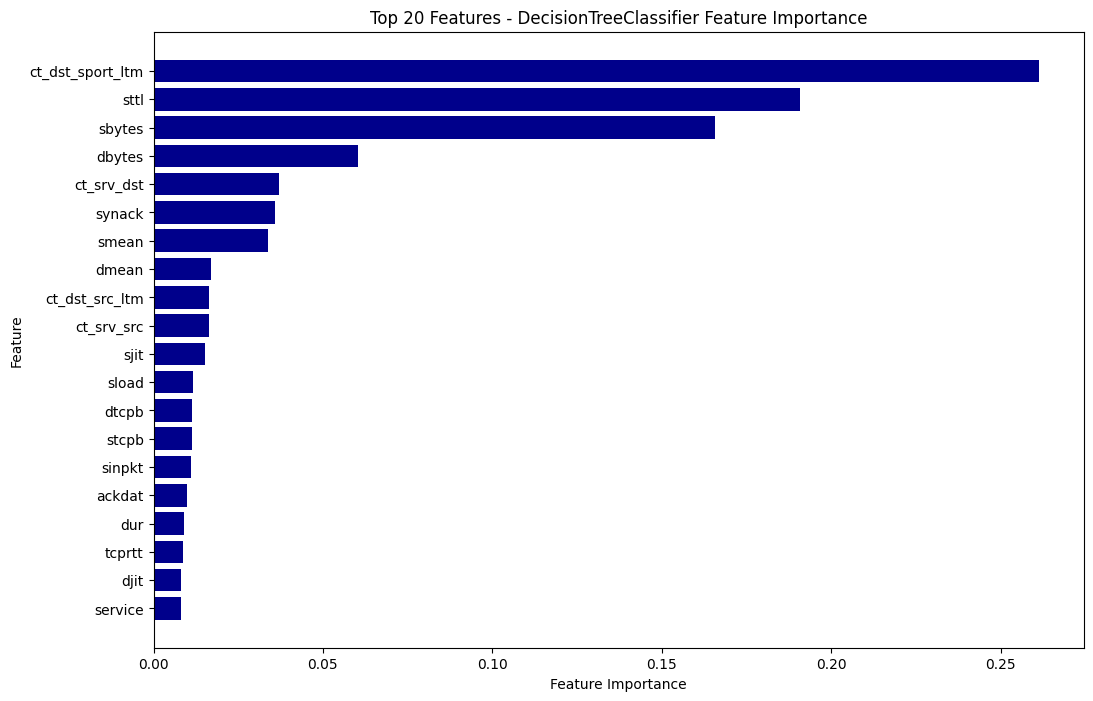

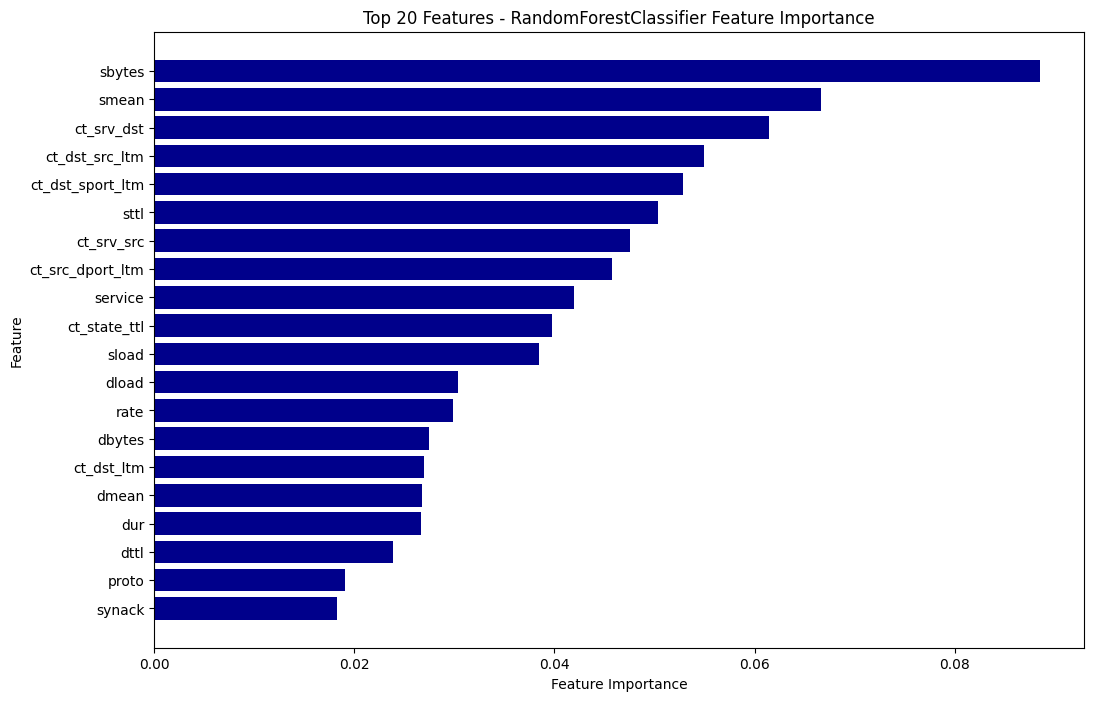

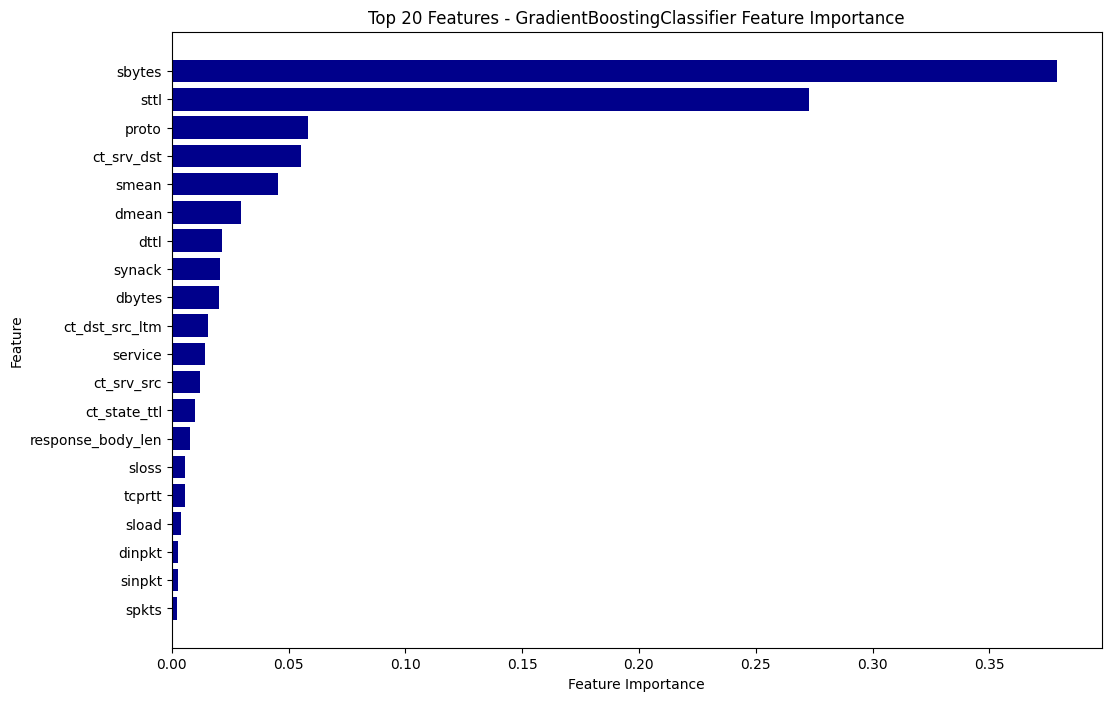

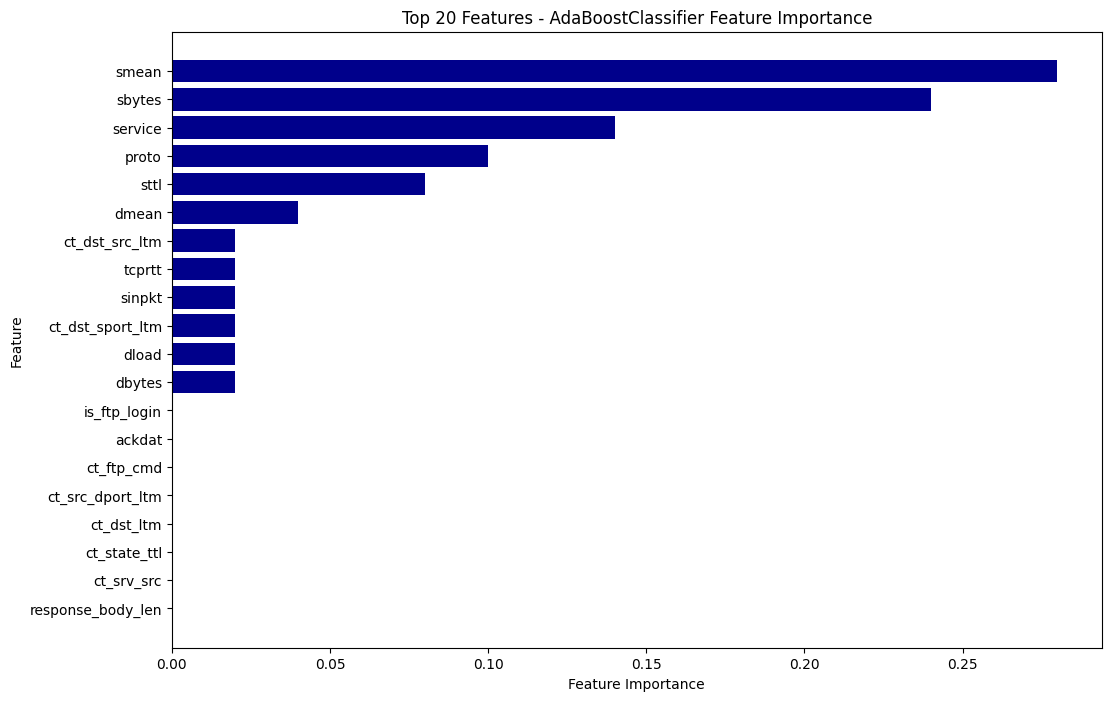

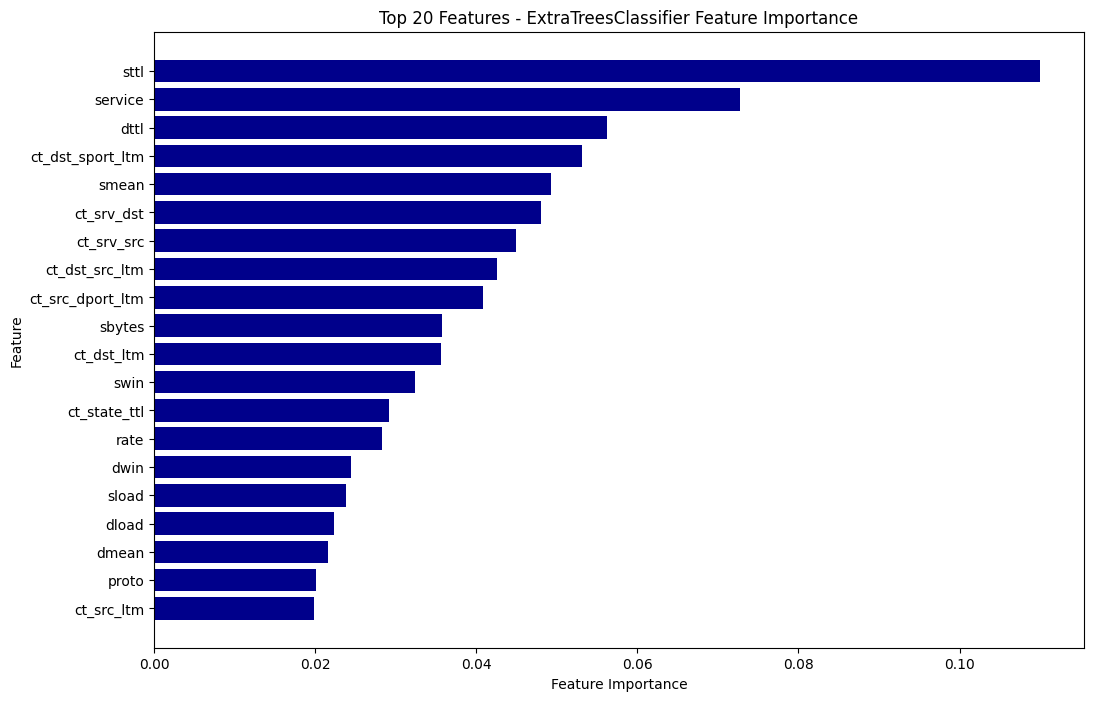

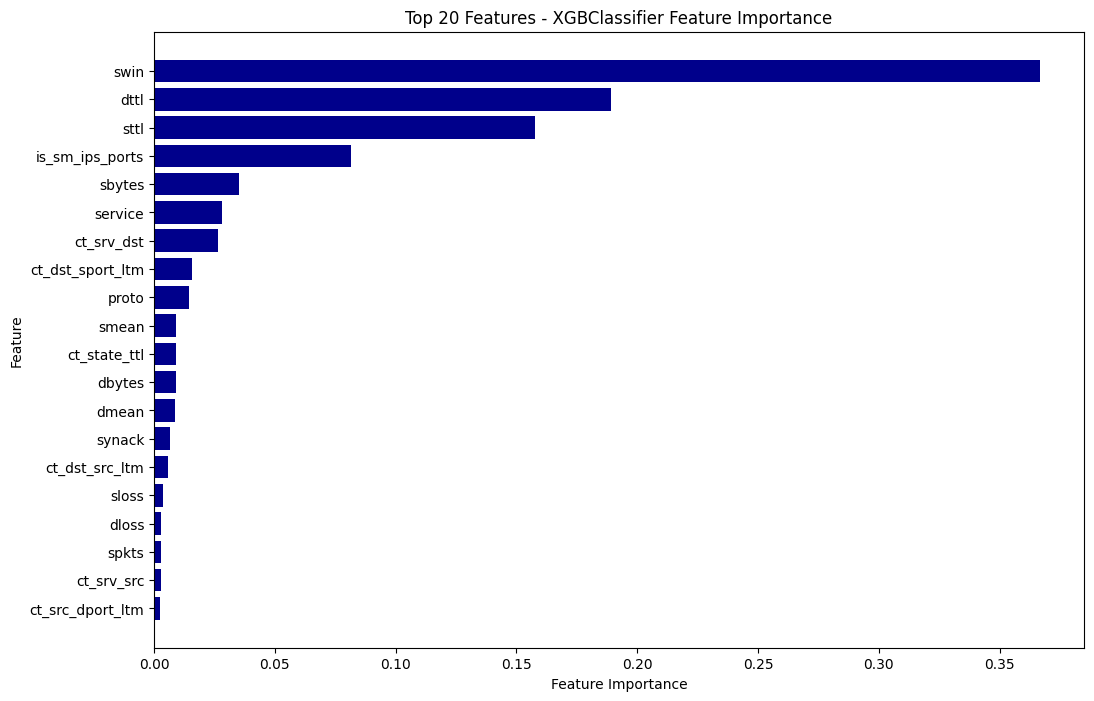

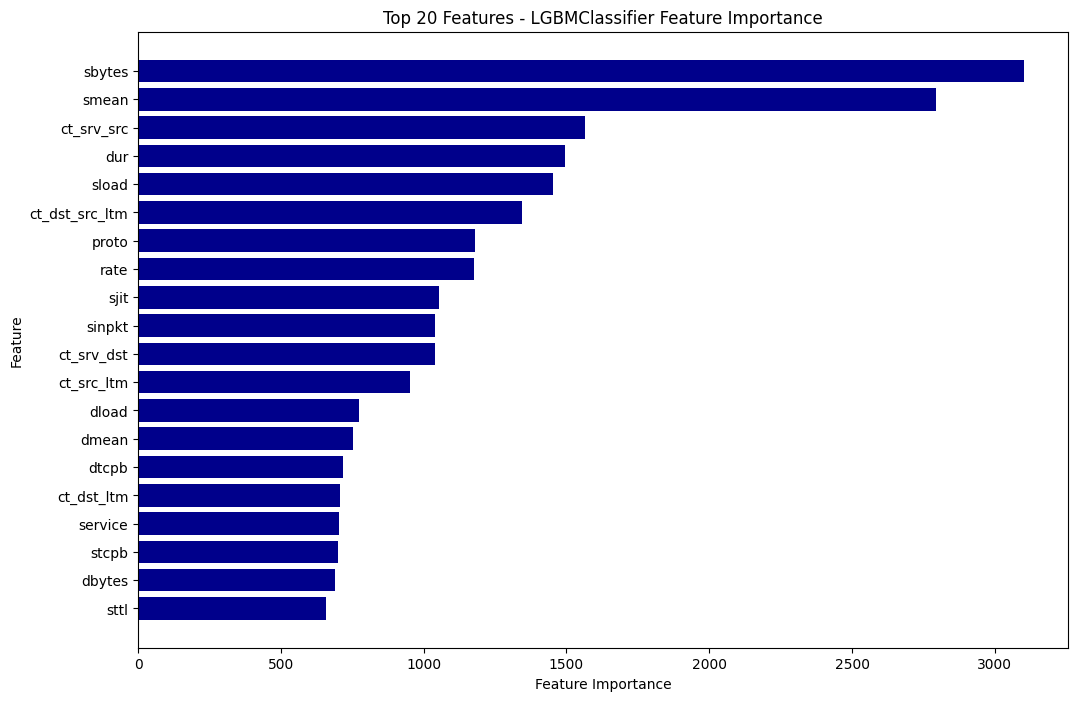

In [ ]:
for model in models:
  try:
    # Get feature names
    feature_names = list(X.columns)

    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    top_n = 20
    top_features = feature_importance_df.head(top_n)

    # Plot the top features
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'], color='darkblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {type(model).__name__} Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.show()
  except Exception as e:
    continue

In [ ]:
top_20_features_df = df[top_features['Feature']]
top_20_features_df.head()

,sbytes,smean,ct_srv_src,dur,sload,ct_dst_src_ltm,proto,rate,sjit,sinpkt,ct_srv_dst,ct_src_ltm,dload,dmean,dtcpb,ct_dst_ltm,service,stcpb,dbytes,sttl
0,258,43,1,0.121478,14158.942380,1,113,74.087490,30.177547,24.295600,1,1,8495.365234,43,2202533631,1,0,621772692,172,252
1,734,52,43,0.649902,8395.112305,2,113,78.473372,61.426934,49.915000,6,1,503571.312500,1106,3077387971,1,0,1417884146,42014,62
2,364,46,7,1.623129,1572.271851,3,113,14.170161,17179.586860,231.875571,6,2,60929.230470,824,2963114973,2,0,2116150707,13186,62
3,628,52,1,1.681642,2740.178955,3,113,13.677108,259.080172,152.876547,1,2,3358.622070,64,1047442890,2,3,1107119177,770,62
4,534,53,43,0.449454,8561.499023,40,113,33.373826,2415.837634,47.750333,39,2,3987.059814,45,1977154190,2,0,2436137549,268,254


# ⨋ Summary

### 💾 Saving model

In [ ]:
# import joblib

# # Save the model to a file
# model_filename = 'recondet_model.joblib'
# joblib.dump(rf_top10_model_ft, model_filename)